### Import Libraries

In [5]:
!pip install tensorflow

In [6]:
import pandas as pd
import numpy as np
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load Dataset

In [7]:
df = pd.read_csv("train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### CREATE label COLUMN

In [8]:
df['label'] = df[
    ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
].max(axis=1)

### NOW Data Exploration Code

In [9]:
# Dataset shape
print("Dataset Shape:", df.shape)

# Column names
print("Columns:", df.columns)

# Missing values
print("\nMissing Values:\n", df.isnull().sum())

# Label distribution
print("\nLabel Distribution:\n", df['label'].value_counts())

Dataset Shape: (159571, 9)
Columns: Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'label'],
      dtype='object')

Missing Values:
 id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
label            0
dtype: int64

Label Distribution:
 label
0    143346
1     16225
Name: count, dtype: int64


In [10]:
##Class Imbalance Check
df['label'].value_counts(normalize=True)

label
0    0.898321
1    0.101679
Name: proportion, dtype: float64

In [11]:
###2️⃣ Comment Length Analysis
df['comment_length'] = df['comment_text'].apply(lambda x: len(x.split()))

df['comment_length'].describe()

count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: comment_length, dtype: float64

In [12]:
###3️⃣ Sample Toxic vs Non-Toxic Comments
print("Toxic comment example:")
print(df[df['label'] == 1]['comment_text'].iloc[0])

print("\nNon-Toxic comment example:")
print(df[df['label'] == 0]['comment_text'].iloc[0])

Toxic comment example:
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

Non-Toxic comment example:
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


### Text Cleaning + Stopword Removal

In [13]:
import re
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()                      # lowercase
    text = re.sub(r'[^a-zA-Z]', ' ', text)   # remove special characters
    text = text.split()                      # tokenization (word split)
    text = [word for word in text if word not in stop_words]  # stopword removal
    return " ".join(text)

df['clean_comment'] = df['comment_text'].apply(clean_text)

df[['comment_text', 'clean_comment']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,comment_text,clean_comment
0,Explanation\nWhy the edits made under my usern...,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,aww matches background colour seemingly stuck ...
2,"Hey man, I'm really not trying to edit war. It...",hey man really trying edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",make real suggestions improvement wondered sec...
4,"You, sir, are my hero. Any chance you remember...",sir hero chance remember page


### Train–Test Split

In [14]:
from sklearn.model_selection import train_test_split

X = df['clean_comment']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)

(127656,) (31915,)


### Tokenization (Text → Numbers)

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

### Vectorization (Padding)

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 150

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding='post')

print("Train shape:", X_train_pad.shape)
print("Test shape:", X_test_pad.shape)

Train shape: (127656, 150)
Test shape: (31915, 150)


### Train Deep Learning Model (LSTM)

In [17]:
##LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
vocab_size = 10000
embedding_dim = 128
max_length = 150

lstm_model = Sequential([
    Input(shape=(max_length,)),                 # Explicit input shape
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(128),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 150, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,411,713 (5.39 MB)

 Trainable params: 1,411,713 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

### Train LSTM Model

In [19]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

lstm_history = lstm_model.fit(
    X_train_pad,
    y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 566s 282ms/step - accuracy: 0.9012 - loss: 0.3271 - val_accuracy: 0.9101 - val_loss: 0.3015
Epoch 2/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 581s 291ms/step - accuracy: 0.9063 - loss: 0.3116 - val_accuracy: 0.9170 - val_loss: 0.2821
Epoch 3/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 630s 295ms/step - accuracy: 0.9027 - loss: 0.2813 - val_accuracy: 0.8993 - val_loss: 0.2650
Epoch 4/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 588s 278ms/step - accuracy: 0.9021 - loss: 0.2986 - val_accuracy: 0.8998 - val_loss: 0.2681
Epoch 5/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 561s 277ms/step - accuracy: 0.9345 - loss: 0.1804 - val_accuracy: 0.9537 - val_loss: 0.1394
Epoch 6/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 557s 279ms/step - accuracy: 0.9602 - loss: 0.1103 - val_accuracy: 0.9614 - val_loss: 0.1126
Epoch 7/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 641s 321ms/step - accuracy: 0.9698 - loss: 0.0748 - val_accuracy: 0.9605 - val_loss: 0.1235
Epoch 9/10
1972/1995 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step - accu

In [21]:
##Evaluate LSTM
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_pad, y_test)
print("LSTM Test Accuracy:", lstm_accuracy)

998/998 ━━━━━━━━━━━━━━━━━━━━ 64s 64ms/step - accuracy: 0.9614 - loss: 0.1126
LSTM Test Accuracy: 0.9613974690437317


### CNN MODEL

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

In [23]:
vocab_size = 10000
embedding_dim = 128
max_length = 150

cnn_model = Sequential([
    Input(shape=(max_length,)),
    Embedding(vocab_size, embedding_dim),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 150, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 146, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,362,177 (5.20 MB)

 Trainable params: 1,362,177 (5.20 MB)

 Non-trainable params: 0 (0.00 B)

### Train CNN Model

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

cnn_history = cnn_model.fit(
    X_train_pad,
    y_train,
    validation_data=(X_test_pad, y_test),
    epochs=5,          # 5 epochs pothum experiment-ku
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 212s 105ms/step - accuracy: 0.9491 - loss: 0.1460 - val_accuracy: 0.9571 - val_loss: 0.1204
Epoch 2/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 261s 105ms/step - accuracy: 0.9626 - loss: 0.1024 - val_accuracy: 0.9576 - val_loss: 0.1212
Epoch 3/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 250s 98ms/step - accuracy: 0.9714 - loss: 0.0790 - val_accuracy: 0.9553 - val_loss: 0.1323
Epoch 4/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 212s 103ms/step - accuracy: 0.9788 - loss: 0.0598 - val_accuracy: 0.9545 - val_loss: 0.1543


In [25]:
loss, accuracy = cnn_model.evaluate(X_test_pad, y_test)
print("CNN Test Accuracy:", accuracy)

998/998 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9571 - loss: 0.1204
CNN Test Accuracy: 0.9571048021316528


In [26]:
###Get LSTM Accuracy
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_pad, y_test)
print("LSTM Test Accuracy:", lstm_accuracy)

998/998 ━━━━━━━━━━━━━━━━━━━━ 56s 56ms/step - accuracy: 0.9614 - loss: 0.1126
LSTM Test Accuracy: 0.9613974690437317


In [27]:
###Get CNN Accuracy
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_pad, y_test)
print("CNN Test Accuracy:", cnn_accuracy)

998/998 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9571 - loss: 0.1204
CNN Test Accuracy: 0.9571048021316528


In [28]:
##Print Comparison Clearly
print("\nModel Comparison")
print("-----------------")
print(f"LSTM Test Accuracy : {lstm_accuracy:.4f}")
print(f"CNN Test Accuracy  : {cnn_accuracy:.4f}")


Model Comparison
-----------------
LSTM Test Accuracy : 0.9614
CNN Test Accuracy  : 0.9571


In [29]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": ["LSTM", "CNN"],
    "Test Accuracy": [lstm_accuracy, cnn_accuracy]
})

comparison_df

,Model,Test Accuracy
0,LSTM,0.961397
1,CNN,0.957105


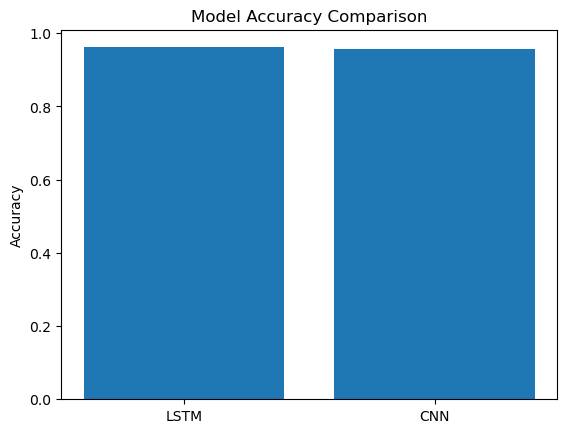

In [30]:
###Visual Comparison Graph
import matplotlib.pyplot as plt

plt.bar(comparison_df["Model"], comparison_df["Test Accuracy"])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

In [31]:
print("LSTM Accuracy:", lstm_accuracy)
print("CNN Accuracy:", cnn_accuracy)

LSTM Accuracy: 0.9613974690437317
CNN Accuracy: 0.9571048021316528


### Final Model Selection
LSTM Accuracy: 0.9613

CNN Accuracy : 0.9571

LSTM slightly better.

So LSTM is selected as final model.

### Save Final LSTM Model

In [33]:
lstm_model.save("final_toxicity_lstm_model.keras")

### Save Tokenizer

In [34]:
import pickle

with open("final_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)